# Human Skeleton Pose dataset creation (.csv) - used for KNN prediction

Setup

In [1]:
import cv2
import mediapipe as mp
import time
import numpy as np
import pandas as pd
import json
import os

mpPose = mp.solutions.pose
pose   = mpPose.Pose()
mpDraw = mp.solutions.drawing_utils # For drawing keypoints
points = mpPose.PoseLandmark # Landmarks

path     = "DATASET/TRAIN" # enter dataset path
new_path = "CNN_DATASET/TRAIN" # enter dataset path for CNN training

data   = []

for p in points:
        x = str(p)[13:]
        data.append(x + "_x")
        data.append(x + "_y")
        data.append(x + "_z")
        data.append(x + "_vis")
data.append('target')               # added the target field depicting the group 0, 1, ...
data = pd.DataFrame(columns = data) # Empty dataset


Build the dataset (dataset3.csv) from image in a folder, and the class name taken from the folder name (class_name.json)

In [2]:
count  = 0
countF = 0
target = 0

class_name = []

for folder in os.listdir(path):
    for img in os.listdir(path + "/" + folder):
        temp = []
        img  = cv2.imread(path + "/" + folder + "/" + img)
        imageWidth, imageHeight = img.shape[:2]
        imgRGB  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #blackie = np.zeros(img.shape) # Blank image
        results = pose.process(imgRGB)

        if results.pose_landmarks:
                mpDraw.draw_landmarks(img, results.pose_landmarks, mpPose.POSE_CONNECTIONS) #draw landmarks on image
                #mpDraw.draw_landmarks(blackie, results.pose_landmarks, mpPose.POSE_CONNECTIONS) # draw landmarks on blackie
                landmarks = results.pose_landmarks.landmark

                for i,j in zip(points,landmarks):
                        temp = temp + [j.x, j.y, j.z, j.visibility]

                temp = temp + [target]
                data.loc[count] = temp
                # write landmarked image in a different folder for CNN training
                cv2.imwrite(new_path + "/" + folder + "/" + "img" + str(count) + ".jpg", img) 
                count +=1
                
        countF +=1
        cv2.imshow("Image", img)
        #cv2.imshow("blackie",blackie)
        cv2.waitKey(10)

    target = target + 1
    # add the folder name in a target list of actions
    class_name.append(folder)
        
data.to_csv("dataset3.csv") # save the data as a csv file

with open("class_name.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable if the data is nested
    json.dump(class_name, f, indent=2) 

print("Valid images:",count)
print("Total Images:",countF)
print("Class Name:",class_name)

cv2.destroyAllWindows()

Valid images: 2700
Total Images: 2700
Class Name: ['shooting', 'sitting', 'standing']


Testing for accuracy

Accuracy score: 1.0


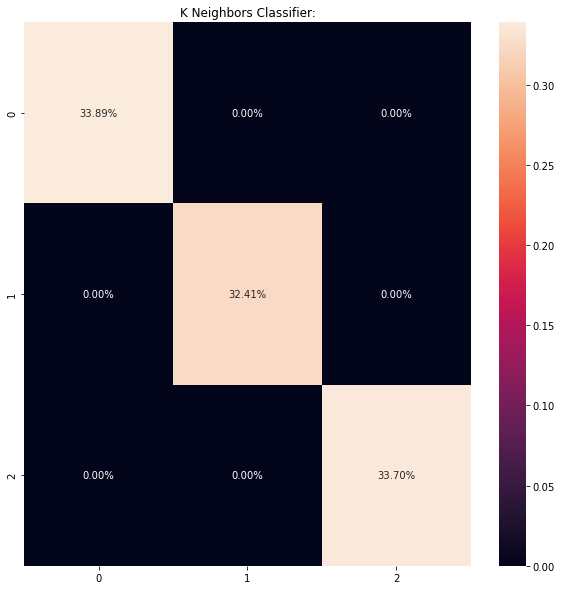

In [10]:
import time
import numpy as np
import pandas as pd
import json
import os

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

data              = pd.read_csv("dataset3.csv",index_col=0) 
features,labels   = data.iloc[:,:132],data['target']  # features are the coordinates, labels is the cathegory

#{using SVC}
#model   = SVC(kernel = 'rbf')

#{using K Neighbors Classifier}  - good standing and sitting
model   = KNeighborsClassifier() # Initialize our classifier

# Split our data
train, test, train_labels, test_labels = train_test_split(features,
                                                          labels,
                                                          test_size=0.20,
                                                          random_state=15)
# fit the data into the model
model.fit(train, train_labels)

# make a prediction
preds = model.predict(test)
#print("Prediction:", preds)

# Evaluate accuracy
print("Accuracy score:", accuracy_score(test_labels, preds))

#Get the confusion matrix
cf_matrix1 = confusion_matrix(test_labels, preds)
plt.figure(figsize=(10, 10))
plt.subplot(111)
sns.heatmap(cf_matrix1/np.sum(cf_matrix1), annot=True, fmt='.2%')
plt.title('K Neighbors Classifier:')
plt.show()


Test an image

standing
Prediction: [2.]


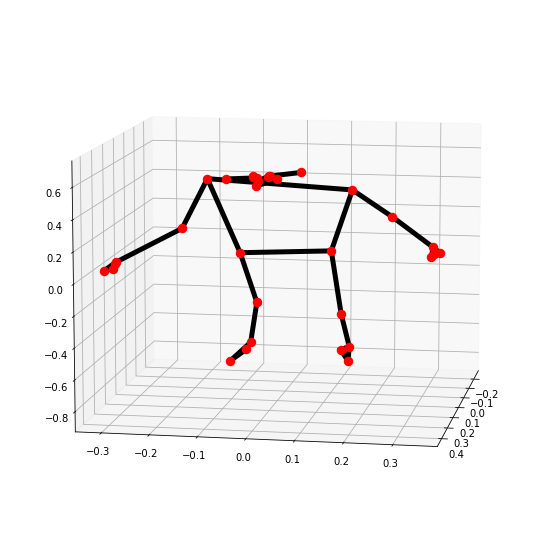

In [9]:

import cv2
import mediapipe as mp
import time
import numpy as np
import pandas as pd
import json
import os
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier # KNN

import warnings
warnings.filterwarnings('ignore')

#mpPose  = mp.solutions.pose
#pose    = mpPose.Pose()
#mpDraw  = mp.solutions.drawing_utils

mp_pose           = mp.solutions.pose
mp_drawing        = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Colors.
blue = (255, 127, 0)
red = (50, 50, 255)
colors = blue

data        = pd.read_csv("dataset3.csv",index_col=0) 
feat, label = data.iloc[:,:132],data['target']

#{using SVC}
#model   = SVC(kernel = 'rbf')

#{using K Neighbors Classifier}  - good standing and sitting
model = KNeighborsClassifier() # Initialize our classifier

model.fit(feat, label) # Train our classifier

with open("class_name.json", 'r') as f:
    class_name = json.load(f)

#IMAGE_FILES = "DATASET/TEST/image003.jpg"   # "enter image path"
#IMAGE_FILES = "DATASET/TEST/image_25.jpg"
#IMAGE_FILES = "DATASET/TEST/image1758.jpg"
#IMAGE_FILES = "DATASET/TEST/frame409.jpg"
IMAGE_FILES = "DATASET/TEST/frame275.jpg"

BG_COLOR = (192, 192, 192) # gray

with mp_pose.Pose(static_image_mode=True,
                  model_complexity=2, 
                  enable_segmentation=True, 
                  min_detection_confidence=0.5) as pose:
    #for idx, file in enumerate(IMAGE_FILES):
        image = cv2.imread(IMAGE_FILES)
        image_height, image_width, _ = image.shape
        # Convert the BGR image to RGB before processing.
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if results.pose_landmarks:
            
            annotated_image = image.copy()

            # Draw segmentation on the image.
            # To improve segmentation around boundaries, consider applying a joint
            # bilateral filter to "results.segmentation_mask" with "image".
            condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
            bg_image = np.zeros(image.shape, dtype=np.uint8)
            bg_image[:] = BG_COLOR
            annotated_image = np.where(condition, annotated_image, bg_image)


            ttemp   = []
            landmarks = results.pose_landmarks.landmark

            for j in landmarks:
                    ttemp = ttemp + [j.x, j.y, j.z, j.visibility]

            preds = model.predict([ttemp])
            asan = class_name[int(preds)]
            if (int(preds) == 0):
                colors = red
            else:
                colors = blue

            print(asan)
            print("Prediction:",preds)
           #print("Landmark:",landmarks)

            #mpDraw.draw_landmarks(img, results.pose_landmarks, mpPose.POSE_CONNECTIONS) #draw landmarks on image
            #mpDraw.draw_landmarks(blackim, results.pose_landmarks, mpPose.POSE_CONNECTIONS) # draw landmarks on blackie
            cv2.putText(annotated_image, asan, (50,50), cv2.FONT_HERSHEY_SIMPLEX,1,colors,3)

            # Draw pose landmarks on the image.
            mp_drawing.draw_landmarks(annotated_image, 
                                      results.pose_landmarks, 
                                      mp_pose.POSE_CONNECTIONS, 
                                      landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
            # Plot pose world landmarks.
            mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS) 

            cv2.imshow("image",annotated_image)
            cv2.imshow("reference pose image",image)

cv2.waitKey(0)
cv2.destroyAllWindows()


Test using the webcam

In [4]:
import cv2
import mediapipe as mp
import time
import numpy as np
import pandas as pd
import json
import os
#from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier # KNN
#from sklearn.neural_network import MLPClassifier # MLP
#from sklearn.ensemble import RandomForestClassifier # RandomForest
#from sklearn.tree import DecisionTreeClassifier # Decision Tree

import warnings
warnings.filterwarnings('ignore')

mp_pose           = mp.solutions.pose
pose              = mp_pose.Pose()
mp_drawing        = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Colors.
blue = (255, 127, 0)
red = (50, 50, 255)
colors = blue

data        = pd.read_csv("dataset3.csv",index_col=0) 
feat, label = data.iloc[:,:132],data['target']

#{using SVC}  - some issues
#model = SVC(kernel = 'poly')

#{using RandomForestClassifier}  - good standing
#model = RandomForestClassifier() # Initialize our classifier

#{using Decision Tree Classifier}  - some issues
#model = DecisionTreeClassifier() # Initialize our classifier

#{using K Neighbors Classifier}  - good standing and sitting
model = KNeighborsClassifier() # Initialize our classifier

#{using MLPClassifier}  - some issues
#model = MLPClassifier() # Initialize our classifier

model.fit(feat, label) # Train our classifier

with open("class_name.json", 'r') as f:
    class_name = json.load(f)

asan    = ""

# For webcam input:
cap = cv2.VideoCapture(3)  # my webcam is 3, yours mighht be 0 or another number, start at 0 and try until it work.
with mp_pose.Pose(min_detection_confidence=0.6, min_tracking_confidence=0.6) as pose:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
            continue

        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        #image   = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # extracting the landmark for the prediction
        ttemp   = []
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            for j in landmarks:
                    ttemp = ttemp + [j.x, j.y, j.z, j.visibility]

            preds = model.predict([ttemp])
            asan = class_name[int(preds)]
            if (int(preds) == 0):
                colors = red
            else:
                colors = blue

        # Draw the pose annotation on the image.
        image.flags.writeable = True
        #image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        mp_drawing.draw_landmarks(
            image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        #cv2.putText(image, asan, (50,50), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,0),3)
        cv2.putText(image, asan, (50,50), cv2.FONT_HERSHEY_SIMPLEX,1,colors,3)
        
        # Flip the image horizontally for a selfie-view display.
        #cv2.imshow('MediaPipe Pose', cv2.flip(image, 1))
        cv2.imshow('MediaPipe Pose', image)
        
        if cv2.waitKey(5) & 0xFF == 27:
            break

cap.release()
cv2.destroyAllWindows()
